In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling3D, AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.metrics import f1_score

from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import random
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from os import *
from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [3]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/img1.png')
    plt.show()
    
    return conf_matx

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.show()
    
    return fig

In [5]:
def loadImages():

    image_list = []
    

    for filename in sorted(glob.glob('/home/jovyan/DATA_MASTER_PROJECT/IMAGES_MASTER_PROJECT/Cropped_Image/Cropped_T_10_5_classes_conc_170/*.tiff'), key=natural_keys): 
        im=cv2.imread(filename)
        imarray = np.array(im)
        imarray = imarray.astype('float32')
        image_list.append(imarray)

    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))
    
    path = '/home/jovyan/DATA_MASTER_PROJECT/leb_T10_P276_conc_170.csv'    
    labels = pd.read_csv(path, usecols=["Type", "Category"],
                       sep="," )
    y_orig = np.array(labels['Category'])

    return x_orig, y_orig

In [6]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

In [7]:
x_orig_1, y_orig_1 = tqdm.tqdm(loadImages())
x_orig_1.shape, y_orig_1.shape

100%|██████████| 2/2 [00:00<00:00, 5797.24it/s]


((29407, 90, 90, 3), (29407,))

In [8]:
# def resize():
#     rescaled = []

#     for i in x_orig_1:

#         scale_percent = 150 # percent of original size
#         width = int(i.shape[1] / (scale_percent / 100))
#         height = int(i.shape[0] / (scale_percent / 100))
#         dim = (width, height)
#         resized = cv2.resize(i, dim, interpolation = cv2.INTER_AREA)
#         rescaled.append(resized)

#     x_orig = np.reshape( rescaled, (len( rescaled), resized.shape[1], resized.shape[1], 3))

#     return x_orig

In [9]:
# x_orig_1 = resize()

In [10]:
x_orig_1 = x_orig_1/255


In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_orig_1, y_orig_1, test_size=0.2, random_state=99 )
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((23525, 90, 90, 3), (5882, 90, 90, 3), (23525,), (5882,))

In [12]:
x_train_1, x_val, y_train_1, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=99 )
x_train_1.shape, x_val.shape, y_train_1.shape, y_val.shape

((18820, 90, 90, 3), (4705, 90, 90, 3), (18820,), (4705,))

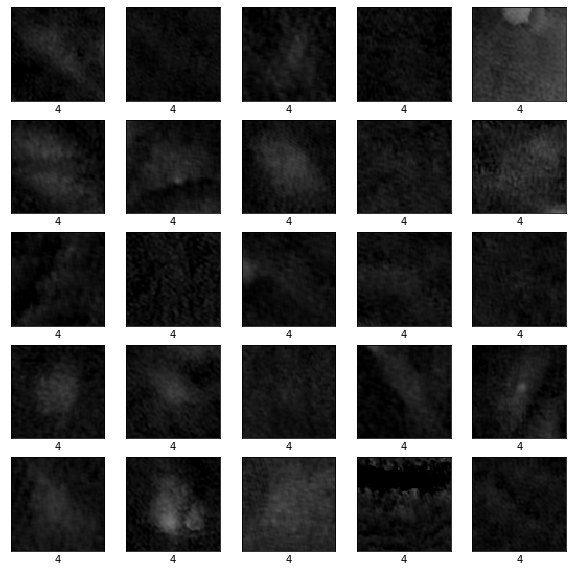

In [13]:
#Show n rabdom images to check for quality

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_1[i], cmap=plt.cm.binary)
    plt.xlabel(y_orig_1[i])
plt.show()

In [14]:
unique, counts = np.unique(y_train_1, return_counts=True)
dict(zip(unique, counts))

{0: 1731, 1: 3119, 2: 3396, 3: 5323, 4: 5251}

In [15]:
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0: 406, 1: 765, 2: 907, 3: 1273, 4: 1354}

In [16]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train_1),y_train_1)
print('weights = ' + str(weights))

weights = [2.17446563 1.20679705 1.10836278 0.70712005 0.71681584]


In [17]:
y_val = keras.utils.to_categorical(y_val)
y_train_1 = keras.utils.to_categorical(y_train_1)
y_test_1 = keras.utils.to_categorical(y_test)


In [18]:
batch_size = 32

In [19]:
datagen = ImageDataGenerator()

datagen.fit(x_train)

train_gen = datagen.flow(x_train_1, y_train_1,batch_size=batch_size )

In [20]:
dat_val = ImageDataGenerator()

dat_val.fit(x_val)

val_gen = dat_val.flow(x_val, y_val,batch_size=batch_size)

In [21]:
input_shape = (90,90,3)

In [22]:
m = Sequential()
m.add(Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu', input_shape = input_shape))
m.add(MaxPooling2D())

m.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
m.add(MaxPooling2D())

m.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
m.add(MaxPooling2D())

m.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
m.add(MaxPooling2D())


m.add(Flatten())

m.add(Dense(128, activation='relu'))
m.add(Dense(5,activation='softmax'))
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 90, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        1

In [23]:
m.compile(loss= categorical_crossentropy,
              optimizer = Adam(lr=1e-3),
             metrics = ['accuracy'])


In [24]:

epochs = 100

m_h = m.fit(train_gen,
                steps_per_epoch=(len(x_train_1)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = (val_gen), 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 588.125 steps, validate for 147.03125 steps
Epoch 1/100
589/588 [==============================] - 8s 13ms/step - loss: 1.3317 - accuracy: 0.4111 - val_loss: 1.2095 - val_accuracy: 0.4990
Epoch 2/100
589/588 [==============================] - 5s 8ms/step - loss: 1.1613 - accuracy: 0.5090 - val_loss: 1.1186 - val_accuracy: 0.5447
Epoch 3/100
589/588 [==============================] - 4s 7ms/step - loss: 1.0740 - accuracy: 0.5536 - val_loss: 1.0900 - val_accuracy: 0.5486
Epoch 4/100
589/588 [==============================] - 5s 8ms/step - loss: 1.0062 - accuracy: 0.5833 - val_loss: 1.0039 - val_accuracy: 0.5957
Epoch 5/100
589/588 [==============================] - 5s 8ms/step - loss: 0.9348 - accuracy: 0.6236 - val_loss: 0.9900 - val_accuracy: 0.6070
Epoch 6/100
589/588 [==============================] - 5s 8ms/step - loss: 0.8694 - accuracy: 0.6528 - val_loss: 0.9649 - val_accuracy: 0.6191
Epoch 7/100
589/588 [================

In [25]:
m.compile(loss= categorical_crossentropy,
              optimizer = Adam(lr=1e-5),
             metrics = ['accuracy'])


In [26]:

epochs = 100

m_h = m.fit(train_gen,
                steps_per_epoch=(len(x_train_1)/batch_size),
                callbacks = [es],
                epochs=epochs,
                validation_data = (val_gen), 
                validation_steps = (len(x_val)/batch_size),
                class_weight = weights)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 588.125 steps, validate for 147.03125 steps
Epoch 1/100
589/588 [==============================] - 5s 9ms/step - loss: 0.4307 - accuracy: 0.8465 - val_loss: 0.9453 - val_accuracy: 0.6693
Epoch 2/100
589/588 [==============================] - 5s 8ms/step - loss: 0.4063 - accuracy: 0.8577 - val_loss: 0.9459 - val_accuracy: 0.6742
Epoch 3/100
589/588 [==============================] - 5s 8ms/step - loss: 0.3942 - accuracy: 0.8619 - val_loss: 0.9516 - val_accuracy: 0.6723
Epoch 4/100
589/588 [==============================] - 5s 8ms/step - loss: 0.3856 - accuracy: 0.8646 - val_loss: 0.9563 - val_accuracy: 0.6735
Epoch 00004: early stopping


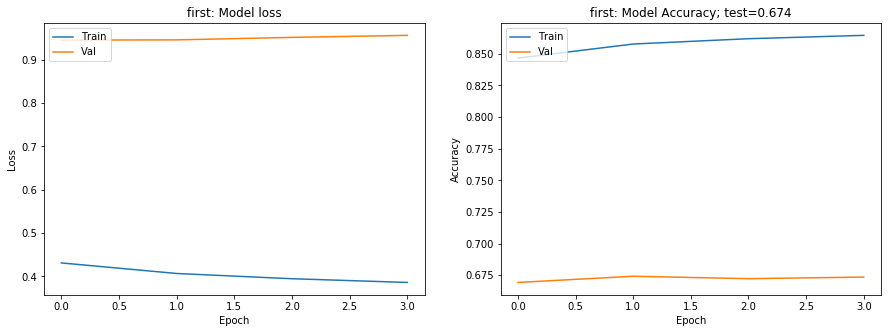

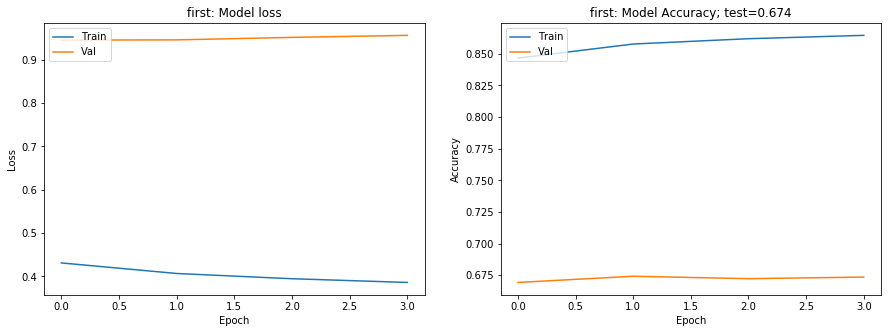

In [27]:
plot_history(m_h, 'first')

In [28]:
scores = m.evaluate(x_test, y_test_1)
print("\n%s: %.2f%%" % (m.metrics_names[1], scores[1]*100))

5882/5882 [==============================] - 1s 153us/sample - loss: 0.9936 - accuracy: 0.6692

accuracy: 66.92%


In [29]:
test_preds = m.predict(x_test)

In [30]:
preds_df = pd.DataFrame(test_preds)
predicted_labels = preds_df.idxmax(axis=1)

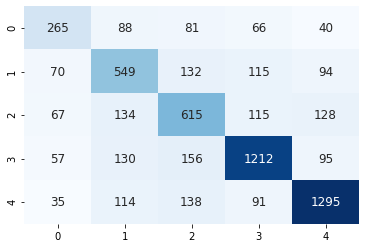

array([[ 265,   88,   81,   66,   40],
       [  70,  549,  132,  115,   94],
       [  67,  134,  615,  115,  128],
       [  57,  130,  156, 1212,   95],
       [  35,  114,  138,   91, 1295]])

In [31]:
draw_confusion_matrix(y_test, predicted_labels)

In [32]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.54      0.49      0.51       540
           1       0.54      0.57      0.56       960
           2       0.55      0.58      0.56      1059
           3       0.76      0.73      0.75      1650
           4       0.78      0.77      0.78      1673

    accuracy                           0.67      5882
   macro avg       0.63      0.63      0.63      5882
weighted avg       0.67      0.67      0.67      5882



In [33]:
p = '/home/jovyan/Saved_Models/'
m.save(p + "Simpel_CNN_P010726_T_10.h5")